In [1]:
from datasets import load_dataset
from transformers import BertTokenizer
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.utils import pad_sequences

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load the PubMed QA dataset
dataset = load_dataset("pubmed_qa","pqa_artificial")

# Extract questions, contexts, and long answers
questions = dataset['train']['question']
contexts = dataset['train']['context']
labels = dataset['train']['final_decision']

questions_and_contexts = [q + " [SEP] " + c['contexts'][0] for q, c in zip(questions, contexts)]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/211269 [00:00<?, ? examples/s]

Dataset pubmed_qa downloaded and prepared to /root/.cache/huggingface/datasets/pubmed_qa/pqa_artificial/1.0.0/2e65addecca4197502cd10ab8ef1919a47c28672f62d7abac7cc9afdcf24fb2d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
dataset_test = load_dataset("pubmed_qa","pqa_labeled")

# Extract questions, contexts, and long answers
questions = dataset_test['train']['question']
contexts = dataset_test['train']['context']
labels_test = dataset_test['train']['final_decision']

questions_and_contexts_test = [q + " [SEP] " + c['contexts'][0] for q, c in zip(questions, contexts)]

  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(questions_and_contexts)
input_data = tokenizer.texts_to_sequences(questions_and_contexts)
input_data = pad_sequences(input_data, maxlen=1024, padding='post')


test_data = tokenizer.texts_to_sequences(questions_and_contexts_test)
test_data = pad_sequences(test_data, maxlen=1024, padding='post')

# Convert labels to one-hot encoded format
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(integer_labels, num_classes=3)

integer_labels_test = label_encoder.fit_transform(labels_test)
categorical_labels_test = to_categorical(integer_labels_test, num_classes=3)

VOCAB_SIZE = len(tokenizer.word_index) + 1

In [13]:
print(len(input_data))
print(len(test_data))

211269
1000


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(VOCAB_SIZE, 512, input_length=1024),
    LSTM(512, return_sequences=True),
    Dropout(0.3),
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    LSTM(256),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
model.fit(input_data, categorical_labels, epochs=5, batch_size=256)

Epoch 1/5
826/826 [==============================] - 1181s 1s/step - loss: 0.2617 - accuracy: 0.9277
Epoch 2/5
826/826 [==============================] - 1178s 1s/step - loss: 0.2590 - accuracy: 0.9284
Epoch 3/5
826/826 [==============================] - 1175s 1s/step - loss: 0.2587 - accuracy: 0.9284
Epoch 4/5
826/826 [==============================] - 1176s 1s/step - loss: 0.2586 - accuracy: 0.9284
Epoch 5/5
826/826 [==============================] - 1178s 1s/step - loss: 0.2587 - accuracy: 0.9284


In [14]:
loss, accuracy = model.evaluate(test_data, categorical_labels_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

32/32 [==============================] - 5s 144ms/step - loss: 7.2821 - accuracy: 0.3380
Test Loss: 7.282079219818115
Test Accuracy: 0.33799999952316284


In [15]:
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)

32/32 [==============================] - 4s 140ms/step


Accuracy: 33.80%
              precision    recall  f1-score   support

       maybe       0.00      0.00      0.00       110
          no       0.34      1.00      0.51       338
         yes       0.00      0.00      0.00       552

    accuracy                           0.34      1000
   macro avg       0.11      0.33      0.17      1000
weighted avg       0.11      0.34      0.17      1000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


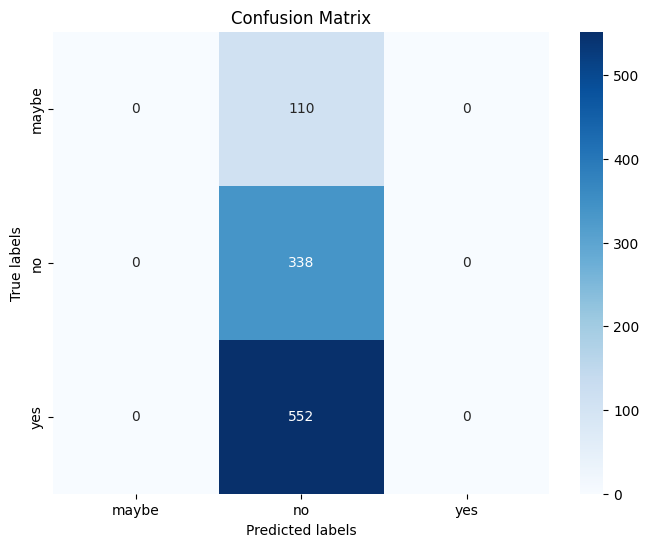

In [18]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `categorical_labels_test` and `predicted_labels` are already defined in your code

# Convert one-hot encoded labels to label-encoded format if they are one-hot encoded
if len(categorical_labels_test.shape) > 1 and categorical_labels_test.shape[1] > 1:
    true_labels = np.argmax(categorical_labels_test, axis=1)
else:
    true_labels = categorical_labels_test

if len(predicted_labels.shape) > 1 and predicted_labels.shape[1] > 1:
    predicted_labels = np.argmax(predicted_labels, axis=1)

# Ensure that both true_labels and predicted_labels have the same shape
assert true_labels.shape == predicted_labels.shape, "Shapes of true_labels and predicted_labels do not match!"

# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification Report (Precision, Recall, F1-score)
report = classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_)
print(report)

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()